In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

filename = "/content/lorenz.txt"

try:
    with open(filename, 'r') as file:
        lines = file.readlines()

    tss = [float(line.strip()) for line in lines]
    print(f"Successfully read {len(tss)} data points from the file.")
except FileNotFoundError:
    print(f"The file {filename} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

time_series_data = np.array(tss)

Successfully read 100001 data points from the file.


In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

class LLE:
    def __init__(self, time_series, dim, delay):
        self.series = time_series
        self.dimension = dim
        self.delay = delay
        self.phase_space = self.build_phase_space()
        self.avg_period = self.compute_avg_period()

    def build_phase_space(self):
        series_length = len(self.series)
        space_dimension = self.dimension
        delay = self.delay

        phase_space_matrix = np.empty((series_length - (space_dimension - 1) * delay, space_dimension))
        for dim_index in range(space_dimension):
            start_index = dim_index * delay
            end_index = series_length - (space_dimension - (dim_index + 1)) * delay
            phase_space_matrix[:, dim_index] = self.series[start_index:end_index]

        return phase_space_matrix

    def find_closest_neighbor(self, point_index, exclusion_zone, lookahead=50):
        total_points = len(self.phase_space)
        candidate_indices = np.arange(total_points - lookahead)
        target_point = self.phase_space[point_index]

        # Calculate distances between the target point and all candidate indices
        distances = np.linalg.norm(self.phase_space[candidate_indices] - target_point, axis=1)

        # Apply the exclusion zone by setting distances to infinity for nearby points
        exclusion_mask = np.abs(candidate_indices - point_index) < exclusion_zone
        distances[exclusion_mask] = np.inf

        # Find the index of the closest neighbor
        closest_neighbor_index = candidate_indices[np.argmin(distances)]
        return closest_neighbor_index

    def identify_neighbors(self, exclusion_zone):
        total_points = len(self.phase_space)

        # Calculate closest neighbors for all points in parallel using list comprehension
        closest_neighbors = [
            self.find_closest_neighbor(idx, exclusion_zone) for idx in range(total_points)
        ]

        return np.array(closest_neighbors)

    def log_distance_average(self, time_step, neighbors):
        log_distances = [np.log(euclidean(self.phase_space[neighbors[idx] + time_step], self.phase_space[idx + time_step]))
                         for idx in range(len(self.phase_space) - time_step)]
        return np.mean(log_distances)

    def estimate_lyapunov(self, end_time=50, linear_fit_length=5):
        closest_neighbors = self.identify_neighbors(self.avg_period)
        log_dist_avg_series = np.array([self.log_distance_average(step, closest_neighbors) for step in range(end_time + 1)])

        time_indices = np.arange(end_time + 1)
        linear_model = LinearRegression().fit(time_indices[:linear_fit_length].reshape(-1, 1), log_dist_avg_series[:linear_fit_length])
        lyapunov_value = linear_model.coef_[0]

        self.visualize_divergence(time_indices, log_dist_avg_series, lyapunov_value, linear_fit_length)
        return lyapunov_value

    def compute_avg_period(self):
        fft_output = np.fft.fft(self.series)
        power_spectra = np.abs(fft_output) ** 2

        num_points = len(self.series)
        freq_step = 1
        frequencies = np.fft.fftfreq(num_points, d=freq_step)
        positive_freq_mask = frequencies > 0
        positive_frequencies = frequencies[positive_freq_mask]
        positive_power_spectra = power_spectra[positive_freq_mask]
        freq_weighted_avg = np.sum(positive_frequencies * positive_power_spectra) / np.sum(positive_power_spectra)
        return 1 / freq_weighted_avg if freq_weighted_avg != 0 else np.inf

    def visualize_divergence(self, steps, log_dists, lyapunov, linear_fit_len):
        plt.plot(steps, log_dists, label='Log Distance Mean', color='darkblue', linewidth=2, marker='o', markersize=3)

        plt.xlabel('Elapsed Time Units', fontsize=12)
        plt.ylabel('Average Logarithmic Separation', fontsize=12)

        plt.title('Trajectory Divergence Analysis', fontsize=14)
        plt.plot(steps[:linear_fit_len], steps[:linear_fit_len] * lyapunov + log_dists[0], 'r--', label='Linear Regression', linewidth=2)

        plt.legend(loc='upper left')

        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()



In [3]:
def logistic_map(n=1000, r=4, x0=0.1):
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = r * x[i-1] * (1 - x[i-1])
    return x

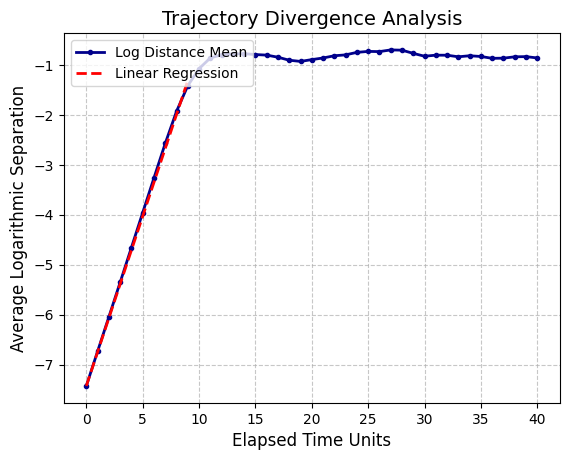

Largest Lyapunov Exponent: 0.6786687642961268


In [4]:
data = logistic_map(n=1000, r=4, x0=0.1)

embedding_dimension = 2

time_delay = 1

calculator = LLE(data, embedding_dimension, time_delay)

lle = calculator.estimate_lyapunov(end_time=40, linear_fit_length=10)

print("Largest Lyapunov Exponent:", lle)

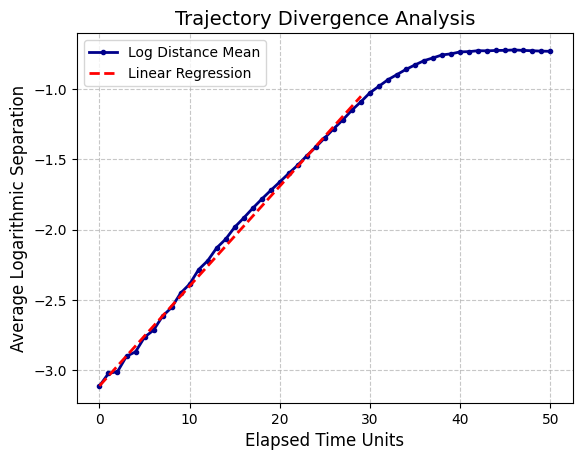

Largest Lyapunov Exponent: 0.07115411162652727


In [5]:
data = time_series_data[:1000]

embedding_dimension = 8

time_delay = 2

calculator = LLE(data, embedding_dimension, time_delay)

lle = calculator.estimate_lyapunov(end_time=50, linear_fit_length=30)

print("Largest Lyapunov Exponent:", lle)